In [1]:
import warnings
warnings.simplefilter(action="ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score

plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

In [2]:
df = pd.read_csv("conversion_data.csv")

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
print("Conversion rate is " + str(round(np.mean(df.converted) * 100,2)) + "%.")

Conversion rate is 3.23%.


# Exploratory Data Analysis

<AxesSubplot:xlabel='age'>

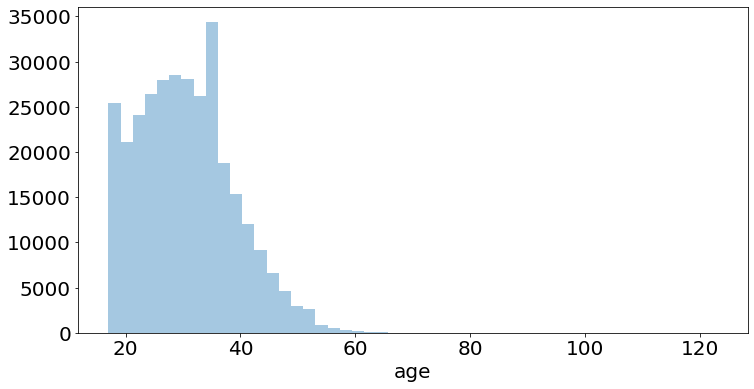

In [7]:
sns.distplot(df['age'],bins=50, kde=False)

In [8]:
df[df['age'] > 80]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


As user age is self-reported in the sign-up stage, it may not be accurate. These two outliers are not in the reasonable range, so I remove these two rows.

In [9]:
df = df[df['age'] < 80]

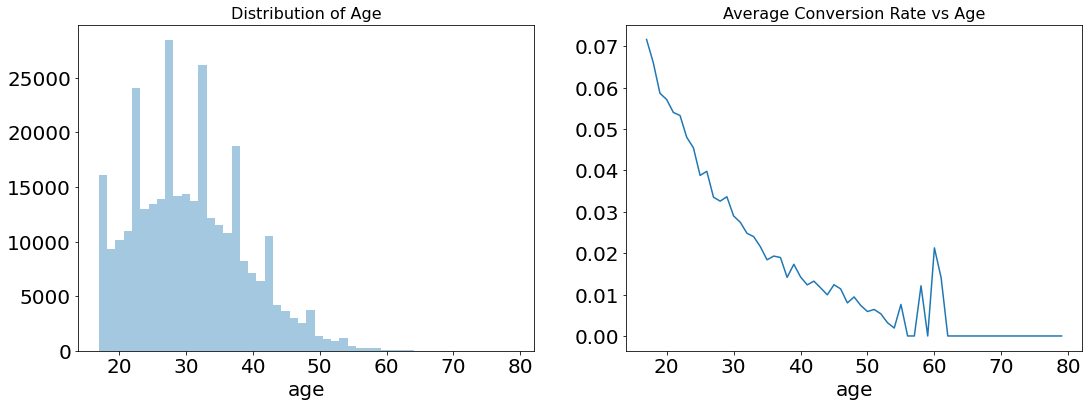

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df['age'],bins=50, kde=False,ax=ax[0])
ax[0].set_title('Distribution of Age', fontsize=16)
df.groupby('age')['converted'].mean().plot(ax=ax[1])
ax[1].set_title('Average Conversion Rate vs Age', fontsize=16)
#plt.tight_layout()
plt.show()

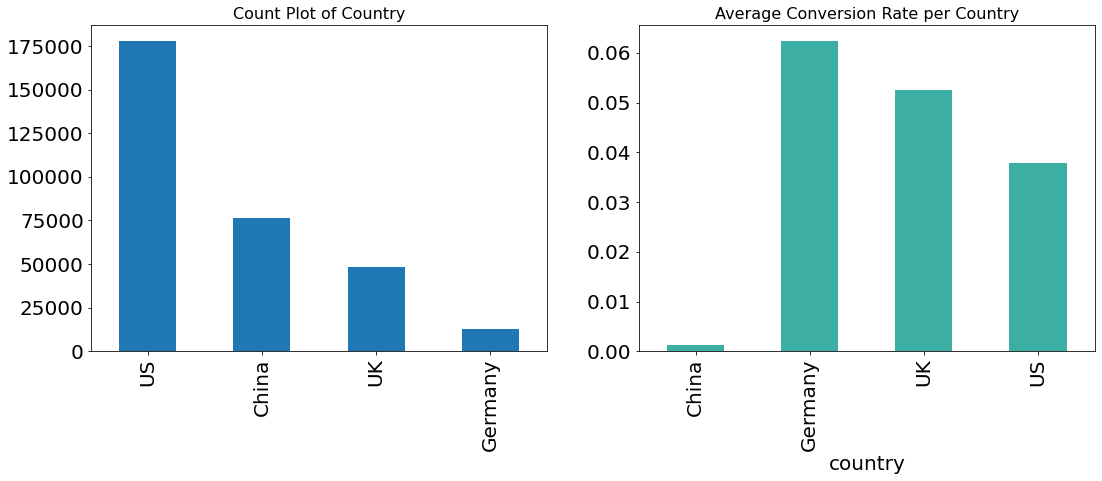

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df['country'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
df.groupby('country')['converted'].mean().plot(kind='bar',ax=ax[1],color='#3CAEA3')
ax[1].set_title('Average Conversion Rate per Country', fontsize=16)
#plt.tight_layout()
plt.show()

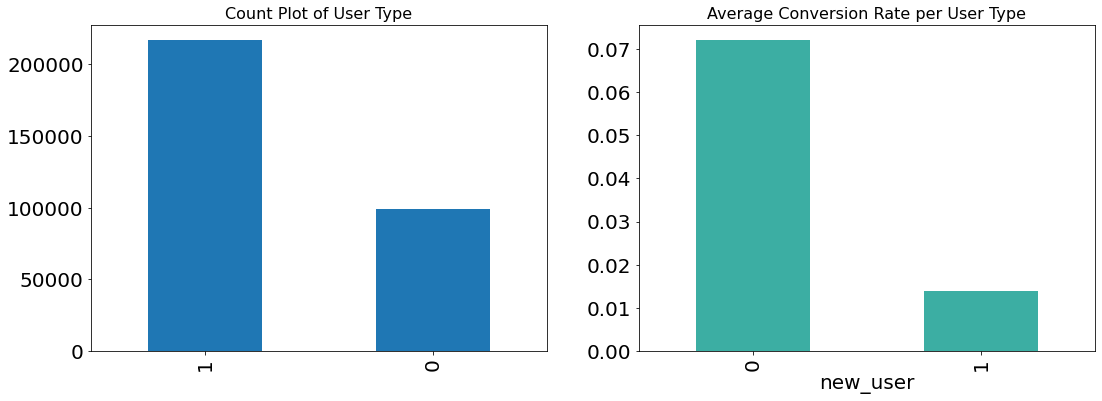

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df['new_user'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot of User Type', fontsize=16)
df.groupby('new_user')['converted'].mean().plot(kind='bar',ax=ax[1],color='#3CAEA3')
ax[1].set_title('Average Conversion Rate per User Type', fontsize=16)
#plt.tight_layout()
plt.show()

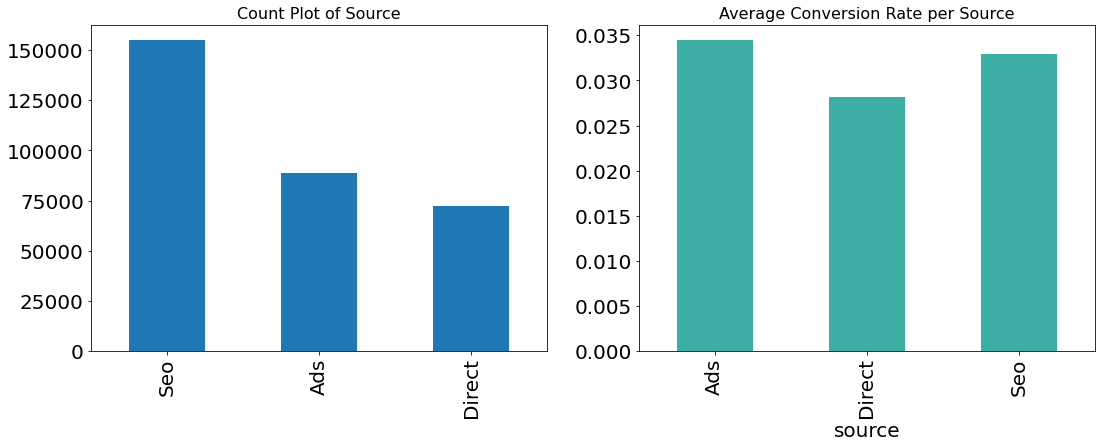

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df['source'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)
df.groupby('source')['converted'].mean().plot(kind='bar',ax=ax[1],color='#3CAEA3')
ax[1].set_title('Average Conversion Rate per Source', fontsize=16)
#plt.tight_layout()
plt.show()

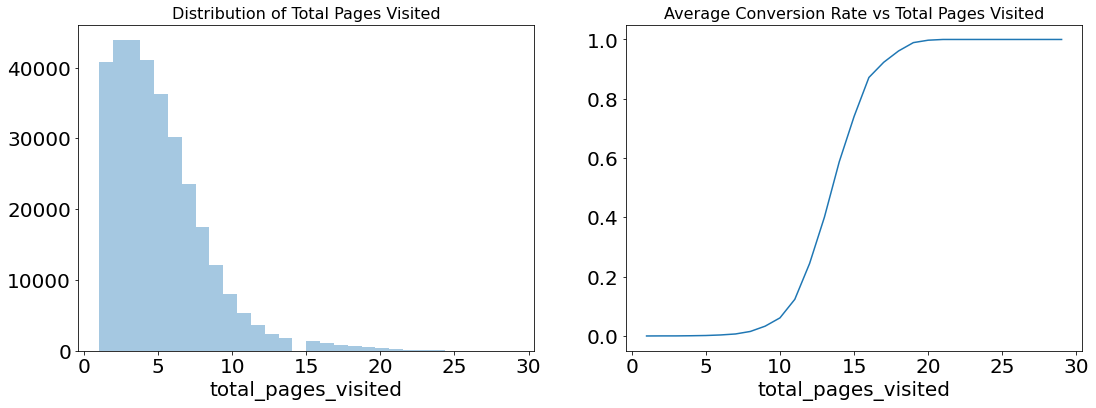

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df['total_pages_visited'],bins=30, kde=False, ax=ax[0])
ax[0].set_title('Distribution of Total Pages Visited', fontsize=16)
df.groupby('total_pages_visited')['converted'].mean().plot(ax=ax[1])
ax[1].set_title('Average Conversion Rate vs Total Pages Visited', fontsize=16)
#plt.tight_layout()
plt.show()

<AxesSubplot:>

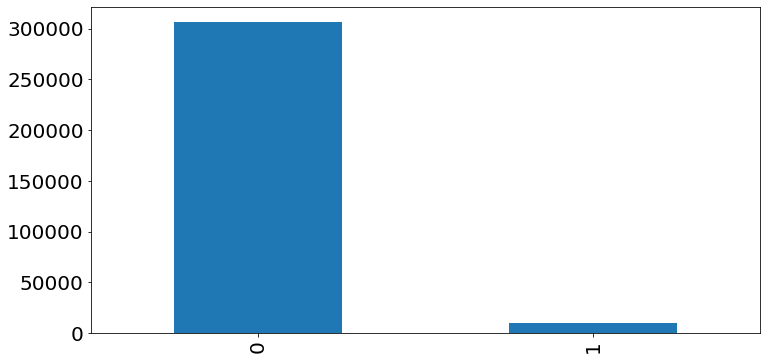

In [15]:
df['converted'].value_counts().plot(kind='bar')

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'new_user'),
  Text(2.5, 0, 'total_pages_visited'),
  Text(3.5, 0, 'converted')])

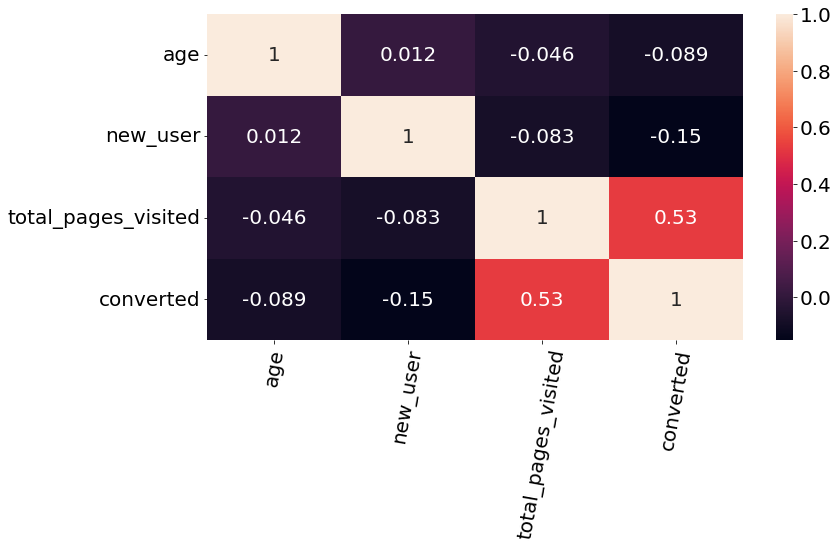

In [16]:
corr_plot = df.corr()
sns.heatmap(corr_plot, annot = True, xticklabels = True, yticklabels = True)
plt.xticks(rotation = 80)

1. The site is probably a US site, although it does have a large Chinese user base as well. However, the conversion rate of Chinese users is significantly lower than users from other countries.
2. User base is pretty young. Conversion Rate decreases as age increases and there is a little peek around 60 y/o.
3. Users with an old account are more likely to place an order than first-time new users.
4. SEO contributes to the most traffic to the site while we can't see much difference in conversion rate among chnnaels.
5. Spending more time on the site implies higher probability of conversion.

# Machine Learning: XGboost

I am going to pick XGBoost to predict conversion rate. I pick a XGBoost model because it usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use XGBoost to predict conversion, then I will use its partial dependence plots and variable importance to get insights about how it got information from the variables.

In [17]:
# One Hot Encode the categorical variables and split data into train and test set
X = pd.get_dummies(df.loc[:, "country":"total_pages_visited"], drop_first=True)
y = df.converted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=100,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=1234,
).fit(X_train, y_train, verbose=True)

In [19]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101029
           1       0.86      0.70      0.77      3317

    accuracy                           0.99    104346
   macro avg       0.93      0.85      0.88    104346
weighted avg       0.99      0.99      0.99    104346



In [20]:
print("AUC score is " + str(round(roc_auc_score(y_test, y_pred),2)))

AUC score is 0.85


We are confident we are not overfitting. Error is pretty low. However, we started from a 97% accuracy (that’s the case if we classified everything as “non converted”). So, 99% is good, but nothing shocking. Indeed, 35% of conversions are predicted as “non conversion”.

In [21]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

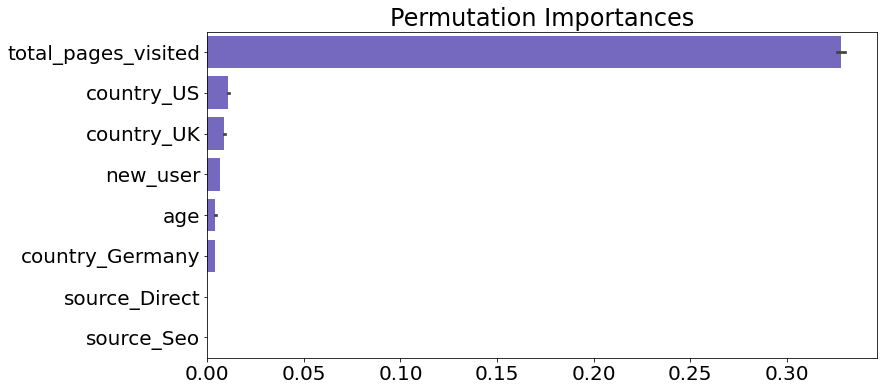

In [22]:
fig = importance(clf, X_train, y_train, X.columns)

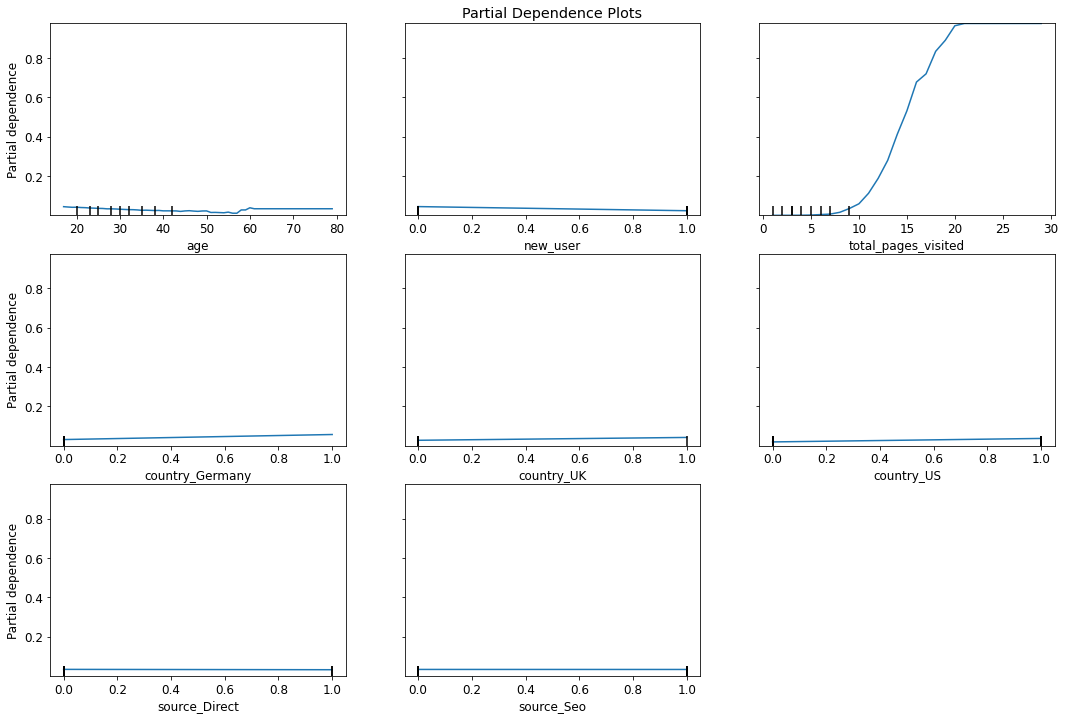

In [23]:
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(18,12))
ax.set_title("Partial Dependence Plots")
fig = PartialDependenceDisplay.from_estimator(clf, X, X.columns, ax=ax)

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages because they already want to buy. Also, in order to buy you have to click on multiple pages.Let’s rebuild XGBoost without that variable. Since classes are heavily unbalanced and that very powerful variable is removed, I will apply weight to the model, just to make sure we will get something classified as 1.

In [24]:
X_train = X_train.drop(columns = ["total_pages_visited"])
X_test = X_test.drop(columns = ["total_pages_visited"])
X = X.drop(columns = ["total_pages_visited"])

In [25]:
clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=20,
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight= 30,
    eval_metric="auc",
    random_state=1234,
).fit(X_train, y_train, verbose=True)

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.75      0.86    101029
           1       0.09      0.73      0.16      3317

    accuracy                           0.75    104346
   macro avg       0.54      0.74      0.51    104346
weighted avg       0.96      0.75      0.83    104346



In [27]:
print("AUC score is " + str(round(roc_auc_score(y_test, y_pred),2)))

AUC score is 0.74


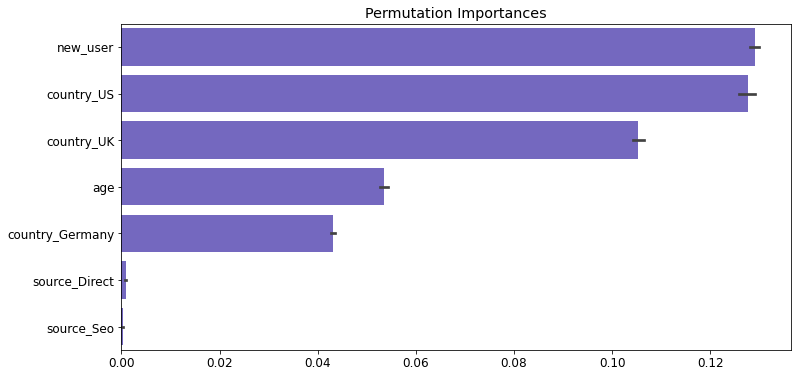

In [28]:
fig = importance(clf, X_train, y_train, X_train.columns)

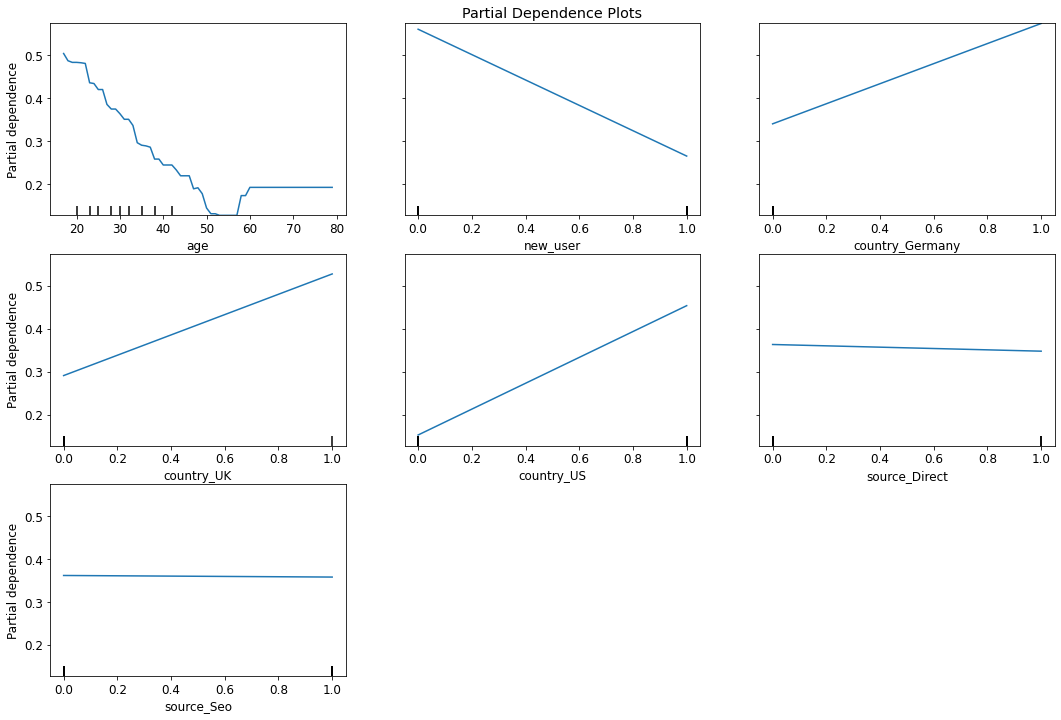

In [29]:
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(18,12))
ax.set_title("Partial Dependence Plots")
fig = PartialDependenceDisplay.from_estimator(clf, X, X.columns, ax=ax)

Accuracy went down, but that’s fine. The model is still good enough to give us insights. New user is the most important one. Source doesn’t seem to matter at all.

# Conlusions and Suggestions

1. The more total pages a user visited, the higher purchase intent. So we could tell the marketing department to send follow-up emails or notifications to those who viewed more than 10 pages but did not place an order.
2. Users with an old account have much higher likelihood to purchase than first-time new users. Targeted emails with offers to bring them back to the site could be a good idea to try.
3. Our website appeals to young users (< 30 y/o) so we could target them through a series marketing campaigns in the acquisition or development stage.
4. German has the lowest number of users and the highest conversion rate, which means German market is a very promosing one but lacks marketing. We should add more marketing on Germans.
5. Chinese market is large while it has extremly low conversion rate. We should dive deep into the reasons behind Chinese users' main concerns or challenges of using our website and fix them ASAP.